![example](images/director_shot.jpeg)

# Project Title

**Authors:** Student 1, Student 2, Student 3
***

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding - ***FILL THIS IN*** 

Describe the data being used for this project.

TO DO
- Add other dataset openings in appendix

***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable? - ROI, average rating, runtime, genres
* What are the properties of the variables you intend to use?
***

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns


%matplotlib inline


# *******MAY NOT NEED THE BELOW**********
import sqlite3
from pandasql import sqldf 
pysqldf = lambda q: sqldf(q, globals())

### Initial Data Review 


In [2]:
conn = sqlite3.Connection(r'C:\Users\Patrick Parkinson\Documents\Flatiron\Projects\Project 1\Working_Repository\Movie-Analysis\zippedData\SQL_data\im.db')

In [3]:
#Joing movie_basics and movie_ratings to access title, runtime, genres, rating

q = """
SELECT *
FROM movie_basics
JOIN movie_ratings
  USING(movie_id)

"""

basic_rate_df = pd.read_sql(q, conn)
basic_rate_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [4]:
basic_rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


Initial basic_rate_df review: 
 - Missing values in runtime and genres but will hold off on addressing knowing we are joining with a smaller data set.
 - Genres will need to be exploded to isolate each genre tagged to each movie

In [5]:
budget_gross_df = pd.read_csv(r'C:\Users\Patrick Parkinson\Documents\Flatiron\Projects\Project 1\Working_Repository\Movie-Analysis\zippedData\tn.movie_budgets.csv.gz')
budget_gross_df.head()


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [6]:
budget_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


Initial basic_rate_df review: 
 - No missing values. Plan to join on 'primary_title' to 'movie'. Investigating primary_title vs. original_title to confirm selection in basic_rate_df below. The 'primary_title' and 'original_title' only seem to differ when original title in different language so 'primary_title' is the correct column to join with 'movie'
 - Poduction_budget, domestic_gross, and worldwide_gross all in string format with dollar sign, need to remove symbol and change to int to produce ROI

In [7]:
#highlighting where 'primary_title' differs from 'original_title'
basic_rate_df[basic_rate_df.primary_title != basic_rate_df.original_title]


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119
8,tt0154039,So Much for Justice!,Oda az igazság,2010,100.0,History,4.6,64
10,tt0162942,Children of the Green Dragon,A zöld sárkány gyermekei,2010,89.0,Drama,6.9,120
12,tt0176694,The Tragedy of Man,Az ember tragédiája,2011,160.0,"Animation,Drama,History",7.8,584
...,...,...,...,...,...,...,...,...
73804,tt9875852,The House Elf,Domovoy,2019,90.0,"Comedy,Family,Fantasy",5.8,50
73824,tt9894394,Upin & Ipin: The Lone Gibbon Kris,Upin & Ipin: Keris Siamang Tunggal,2019,100.0,Animation,8.1,301
73829,tt9899840,Auntie Frog,Khaleh Ghurbagheh,2018,81.0,"Adventure,Comedy,Family",6.2,6
73830,tt9899850,The Agitation,Ashoftegi,2019,NaN,"Drama,Thriller",4.9,14


## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

### Data Merge


In [8]:
br_inc_merged = basic_rate_df.merge(budget_gross_df, how='inner', left_on='primary_title', right_on='movie')
print('br_inc_merged length:',len(br_inc_merged))
br_inc_merged.head()

br_inc_merged length: 2875


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",Foodfight!,"$45,000,000",$0,"$73,706"
1,tt0326592,The Overnight,The Overnight,2010,88.0,None,7.5,24,21,"Jun 19, 2015",The Overnight,"$200,000","$1,109,808","$1,165,996"
2,tt3844362,The Overnight,The Overnight,2015,79.0,"Comedy,Mystery",6.1,14828,21,"Jun 19, 2015",The Overnight,"$200,000","$1,109,808","$1,165,996"
3,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886,17,"Mar 22, 2013",On the Road,"$25,000,000","$720,828","$9,313,302"
4,tt4339118,On the Road,On the Road,2014,89.0,Drama,6.0,6,17,"Mar 22, 2013",On the Road,"$25,000,000","$720,828","$9,313,302"


In [9]:
br_inc_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2875 entries, 0 to 2874
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           2875 non-null   object 
 1   primary_title      2875 non-null   object 
 2   original_title     2875 non-null   object 
 3   start_year         2875 non-null   int64  
 4   runtime_minutes    2757 non-null   float64
 5   genres             2867 non-null   object 
 6   averagerating      2875 non-null   float64
 7   numvotes           2875 non-null   int64  
 8   id                 2875 non-null   int64  
 9   release_date       2875 non-null   object 
 10  movie              2875 non-null   object 
 11  production_budget  2875 non-null   object 
 12  domestic_gross     2875 non-null   object 
 13  worldwide_gross    2875 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 336.9+ KB


In [10]:
missing_runtime=(len(br_inc_merged[br_inc_merged['runtime_minutes'].isna()])/len(br_inc_merged))*100
print('% missing runtime data:', missing_runtime)

% missing runtime data: 4.104347826086956


br_inc_merged Initial Review:
- Merge between basic_rate_df and budget_gross_df yielded 2875 overlapping movies. This is considerably less than 75k+ in SQL database but plan to only overlapping values as ROI data is critical metric for planning
- Runtime minutes still has missing data points. Decision to remove these datapoints as they only represent 4% of total entries. Runtime is also a unique characteristics to each movie and therefore there isn't any great method to make accurate estimations for this value.
- It is possible that we aren't yielding all matches between the basic_rate_df and budget_gross_df if there are slight differents in the titles listed between datasets for the same movie. Exploring this below with a combined and sorted series of the titles between datasets. From review, there does not appear to be consistent formatting differences/typos that can be fixed to yield more data points. 

In [12]:
# br_inc_merged['month'] = br_inc_merged['release_date'].dt.month

### Data Cleaning

In [11]:
#dropping missing values
br_inc_merged.dropna(inplace=True)

In [12]:
#confirmed droped
br_inc_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2752 entries, 0 to 2873
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           2752 non-null   object 
 1   primary_title      2752 non-null   object 
 2   original_title     2752 non-null   object 
 3   start_year         2752 non-null   int64  
 4   runtime_minutes    2752 non-null   float64
 5   genres             2752 non-null   object 
 6   averagerating      2752 non-null   float64
 7   numvotes           2752 non-null   int64  
 8   id                 2752 non-null   int64  
 9   release_date       2752 non-null   object 
 10  movie              2752 non-null   object 
 11  production_budget  2752 non-null   object 
 12  domestic_gross     2752 non-null   object 
 13  worldwide_gross    2752 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 322.5+ KB


In [13]:
#combines titles in both datasets into single series to visualize whether there are repeated 
# typos/formatting differences that could be corrected

pd.set_option('display.max_rows', 10000) 

#creating vars for each title series
basic_rate_pt = basic_rate_df['primary_title'].copy()
budget_gross_pt = budget_gross_df['movie'].copy()

#concat two series together 
pt_concat = pd.concat([basic_rate_pt, budget_gross_pt])

#dropping duplicates so we're only seeing those that aren't included in merge
pt_concat.drop_duplicates(inplace=True)
#sorting alphabetically so potential typos/format differences can be seen
pt_concat.sort_values(ascending=True, inplace=True)

print(pt_concat.iloc[10000: 20000])

1594                                           Bodhisattva
43551                                               Bodhon
57376                                               Bodied
25915                                               Bodies
69044                                       Bodies at Rest
53953                                           Bodkin Ras
61911                                                 Bodo
38546                                                Bodom
7135                                                  Body
13907                                        Body Complete
3640                                           Body Double
61950                                        Body Electric
53643                                            Body Farm
21290                               Body Fat Index of Love
24422                                            Body High
39719                                         Body Keepers
13369                                        Body Langua

### Feature Engineering

In [14]:
#run once to remove $ signs and change dollar amounts to int
br_inc_merged['production_budget'] = br_inc_merged['production_budget'].str.replace(r'[^\w\s]+', '').astype('int64')

br_inc_merged['worldwide_gross'] = br_inc_merged['worldwide_gross'].str.replace(r'[^\w\s]+', '').astype('int64')

# REMOVE br_inc_merged['domestic_gross'] = br_inc_merged['domestic_gross'].str.replace(r'[^\w\s]+', '').astype('int64')

In [15]:
#assume that this is the actual income...budget is actually what was spent

#REMOVE: br_inc_merged['domestic_income'] = br_inc_merged['domestic_gross'] - br_inc_merged['production_budget']

br_inc_merged['worldwide_income'] = br_inc_merged['worldwide_gross'] - br_inc_merged['production_budget']
br_inc_merged['worldwide_ROI'] = (br_inc_merged['worldwide_income'] / br_inc_merged['production_budget'])*100

In [16]:
br_inc_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2752 entries, 0 to 2873
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           2752 non-null   object 
 1   primary_title      2752 non-null   object 
 2   original_title     2752 non-null   object 
 3   start_year         2752 non-null   int64  
 4   runtime_minutes    2752 non-null   float64
 5   genres             2752 non-null   object 
 6   averagerating      2752 non-null   float64
 7   numvotes           2752 non-null   int64  
 8   id                 2752 non-null   int64  
 9   release_date       2752 non-null   object 
 10  movie              2752 non-null   object 
 11  production_budget  2752 non-null   int64  
 12  domestic_gross     2752 non-null   object 
 13  worldwide_gross    2752 non-null   int64  
 14  worldwide_income   2752 non-null   int64  
 15  worldwide_ROI      2752 non-null   float64
dtypes: float64(3), int64(6),

In [17]:
#UPDATE THIS BASED ON WHAT YOU ACTUALLY USE
br_inc_merged.drop(['original_title','start_year', 'numvotes', 'id', 'movie', 'release_date', 'domestic_gross'], axis=1, inplace=True)

Create separate df for genre analysis, explode. Keep separate so majority of analysis in 1 to 1

In [18]:
genre_df = br_inc_merged.copy()

In [19]:
genre_df['genres'] = genre_df['genres'].str.split(',')

In [20]:
genre_df = genre_df.explode('genres')
genre_df.head()

,movie_id,primary_title,runtime_minutes,genres,averagerating,production_budget,worldwide_gross,worldwide_income,worldwide_ROI
0,tt0249516,Foodfight!,91.0,Action,1.9,45000000,73706,-44926294,-99.836209
0,tt0249516,Foodfight!,91.0,Animation,1.9,45000000,73706,-44926294,-99.836209
0,tt0249516,Foodfight!,91.0,Comedy,1.9,45000000,73706,-44926294,-99.836209
2,tt3844362,The Overnight,79.0,Comedy,6.1,200000,1165996,965996,482.998000
2,tt3844362,The Overnight,79.0,Mystery,6.1,200000,1165996,965996,482.998000


## Analysis
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

### Exploratory Data Analysis and Outlier Cleanup - CLEANUP VISUALIZATIONS (ADD UNITS TO TICK LABELS)

There a way I can get all this describe data to show up in a single table????

In [21]:
br_inc_merged.describe()

,runtime_minutes,averagerating,production_budget,worldwide_gross,worldwide_income,worldwide_ROI
count,2752.000000,2752.000000,2.752000e+03,2.752000e+03,2.752000e+03,2752.000000
mean,102.972020,6.243132,3.473329e+07,1.043842e+08,6.965094e+07,305.019968
std,20.786121,1.168073,4.822579e+07,2.034297e+08,1.682778e+08,1493.227031
min,3.000000,1.600000,1.400000e+03,0.000000e+00,-2.002376e+08,-100.000000
25%,90.000000,5.600000,5.000000e+06,2.229406e+06,-2.300000e+06,-69.063376
50%,101.000000,6.400000,1.785000e+07,3.007543e+07,9.873828e+06,58.644429
75%,113.250000,7.100000,4.000000e+07,1.030832e+08,6.612770e+07,258.142857
max,280.000000,9.200000,4.250000e+08,2.776345e+09,2.351345e+09,41556.474000


In [22]:
print('Medians:')
print(br_inc_merged.median())

Medians:
runtime_minutes      1.010000e+02
averagerating        6.400000e+00
production_budget    1.785000e+07
worldwide_gross      3.007543e+07
worldwide_income     9.873828e+06
worldwide_ROI        5.864443e+01
dtype: float64


#### Average Rating

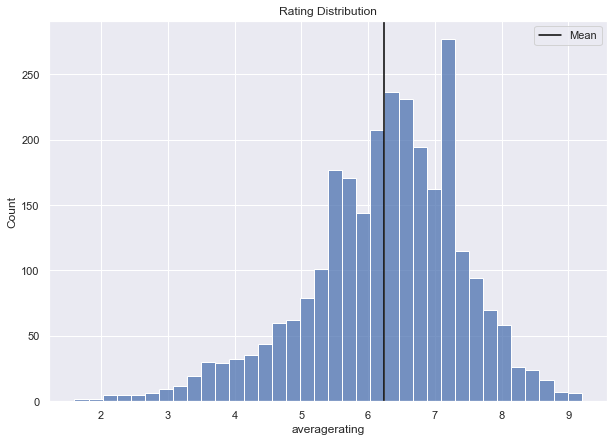

In [23]:
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(figsize=(10,7))
g = sns.histplot(data=br_inc_merged['averagerating'], ax=ax)
g.set(title='Rating Distribution')
# g.axvline(x=br_inc_merged['averagerating'].mean(), color='black', label=str(np.mean(br_inc_merged['averagerating'])))
g.axvline(x=br_inc_merged['averagerating'].mean(), color='black', label='Mean')
g.legend(loc='upper right')

#### Runtime

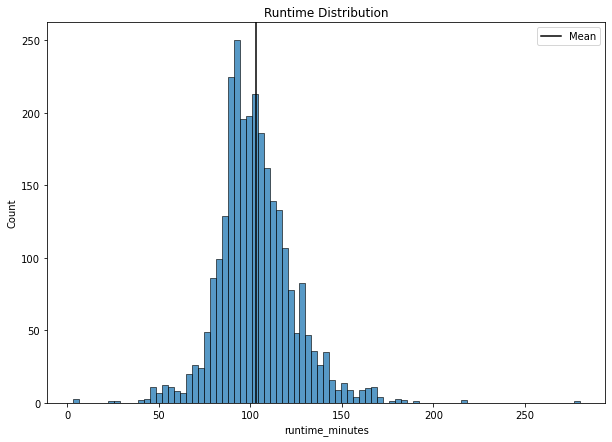

In [13]:
fig, ax = plt.subplots(figsize=(10,7))
g=sns.histplot(data=br_inc_merged['runtime_minutes'], ax=ax)
g.set(title='Runtime Distribution')
g.axvline(x=br_inc_merged['runtime_minutes'].mean(), color='black', label='Mean')
g.legend(loc='upper right')

plt.savefig('runtime_distribution.png')

#### Worldwide Return on Investment (ROI)

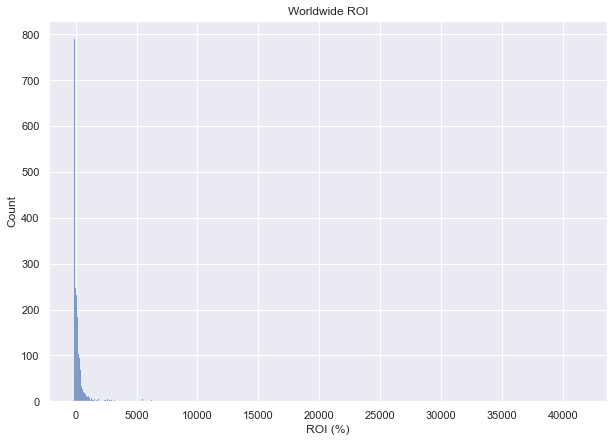

In [25]:
fig, ax = plt.subplots(figsize=(10,7))
g = sns.histplot(data=br_inc_merged['worldwide_ROI'], ax=ax)
g.set(title='Worldwide ROI', xlabel='ROI (%)');

g.set_xticks(range(0, 45000, 5000));

C:\Users\Patrick Parkinson\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


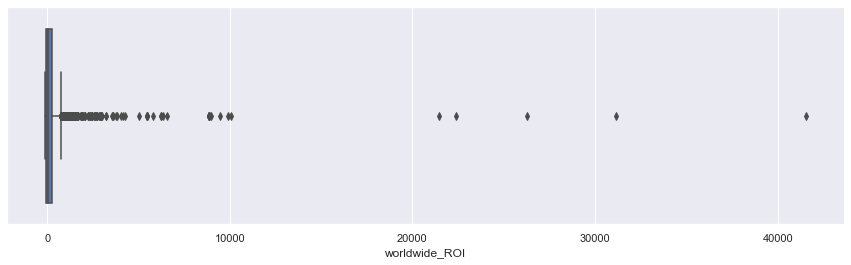

In [26]:
ax, fig = plt.subplots(figsize=(15,4))
g = sns.boxplot(br_inc_merged['worldwide_ROI']);
# g.set_xticks(range(0, 50000, 500));
# xlabels = ['{:,.0f}'.format(x) + 'M' for x in g.get_xticks()/1000000];
# g.set_xticklabels(xlabels, rotation=45);

# plt.xlim([-250, 2000])

In [27]:
#Generate additional chart zoomed in more

Dropping values > 20000...x times greater than ....

This still leaves considerable amount of high ROIs that could throw off results. Create mask without last 5% data

In [28]:
ROI_quant_95 = br_inc_merged['worldwide_ROI'].quantile(0.95)
print('ROI 95th Quantile:', ROI_quant_95)

ROI 95th Quantile: 1086.6198484999993


In [29]:
ROI_max = br_inc_merged['worldwide_ROI'].max()
ROI_top5_ave = br_inc_merged[(br_inc_merged['worldwide_ROI'] > ROI_quant_95) & 
             (br_inc_merged['worldwide_ROI'] < ROI_max)]['worldwide_ROI'].mean()
print('Top 5% ROI, Average:', ROI_top5_ave)

Top 5% ROI, Average: 3550.439414425255


In [30]:
ROI_95th_mask = br_inc_merged['worldwide_ROI'] < ROI_quant_95

#### Genre

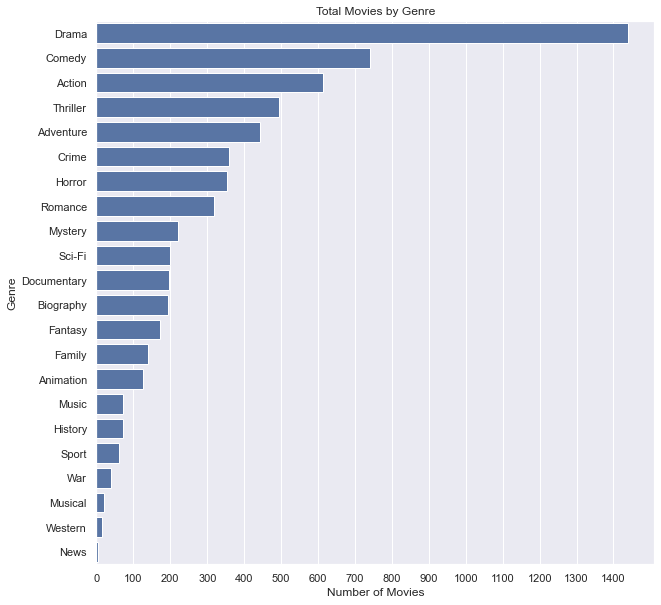

In [31]:
genre_df_counts = genre_df.groupby('genres', as_index=False).count()

fig, ax = plt.subplots(figsize=(10,10))
data_genre_counts = genre_df_counts.sort_values(by='movie_id', ascending=False);
g = sns.barplot(data=data_genre_counts, x='movie_id', y='genres', ax=ax, color='b')
g.set(title='Total Movies by Genre', xlabel='Number of Movies', ylabel='Genre');
g.set_xticks(range(0, 1500, 100));

Drop genres with less than 50 movies from genre dataset only (won't impact rest of analyis)



SHOULD WE RECALCULATE EDA AFTER DROPPING THESE VALUES?

CONSIDER DROPPING OUTLIER RUNTIMES


#### Outlier Cleanup

Summarize outlier cleanup

In [32]:
# print(len(br_inc_merged))

index_drop = br_inc_merged[br_inc_merged['worldwide_ROI'] > 20000].index
index_drop_genre = genre_df[(genre_df['worldwide_ROI'] > 20000)].index

br_inc_merged.drop(index_drop, inplace=True)
genre_df.drop(index_drop_genre, inplace=True)

#ADD genre drop



In [33]:
#annotate this process

genre_counts = genre_df['genres'].value_counts()
genre_to_remove = genre_counts[genre_counts <= 50].index
genre_df = genre_df[~genre_df['genres'].isin(genre_to_remove)]

In [34]:
genre_to_remove

Index(['War', 'Musical', 'Western', 'News'], dtype='object')

### Target Variable Analysis

Quick analysis to see if there is correlation between continuous data columns of interest. There is not strong correlation, analyze in bins

In [35]:
corr_rating_ROI = br_inc_merged['averagerating'].corr(br_inc_merged['worldwide_ROI'])
corr_runtime_ROI = br_inc_merged['runtime_minutes'].corr(br_inc_merged['worldwide_ROI'])
corr_runtime_rating = br_inc_merged['runtime_minutes'].corr(br_inc_merged['averagerating'])

print('Correlation b/w rating and worldwide ROI:', corr_rating_ROI)
print('Correlation b/w runtime and worldwide ROI:', corr_runtime_ROI)
print('Correlation b/w runtime and rating:', corr_runtime_rating)

Correlation b/w rating and worldwide ROI: 0.05359983771306231
Correlation b/w runtime and worldwide ROI: -0.0032232979385874378
Correlation b/w runtime and rating: 0.2125564489954962


Bin explanation, link back to EDA

In [36]:
bins_rating = [0, 2, 4, 6, 8, 10]
labels_rating = ['0-2','2-4','4-6','6-8','8-10']
br_inc_merged['rating_bins'] = pd.cut(br_inc_merged['averagerating'], bins_rating, labels=labels_rating)

bins_runtime = [0, 50, 70, 90, 110, 130, 150, 170, 290]
labels_runtime = ['0-50','50-70','70-90','90-110','110-130','130-150','150-170','170-290']
br_inc_merged['runtime_bins'] = pd.cut(br_inc_merged['runtime_minutes'], bins_runtime, labels=labels_runtime)

#### Rating Investigation

In [37]:
rating_means_df = br_inc_merged.groupby('rating_bins', as_index=False).mean()
rating_means_95th_df = br_inc_merged[ROI_95th_mask].groupby('rating_bins', as_index=False).mean()

<ipython-input-37-3e889e3f9468>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rating_means_95th_df = br_inc_merged[ROI_95th_mask].groupby('rating_bins', as_index=False).mean()


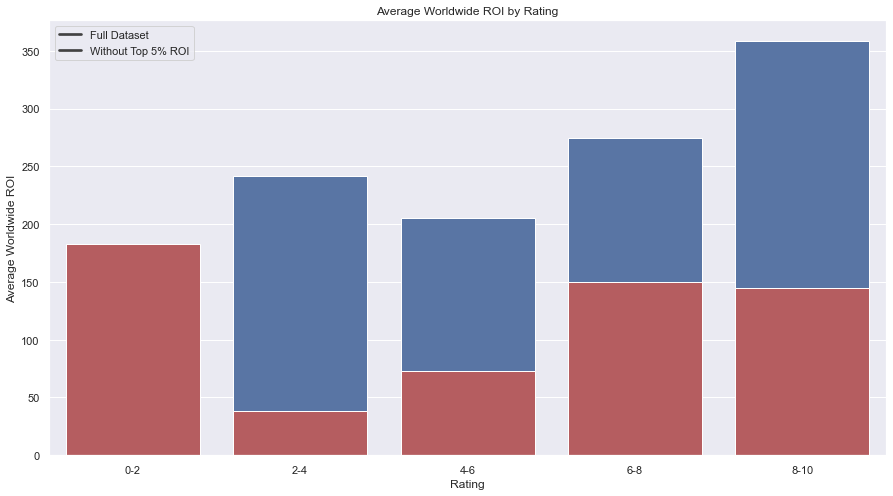

In [46]:
# fig, ax = plt.subplots(figsize=(15,8))
# # data_runtime_means = runtime_means_df.sort_values(by='', ascending=False);
# bar1 = sns.barplot(data=rating_means_df, x='rating_bins', y='worldwide_ROI', ax=ax, color='b')
# bar2 = sns.barplot(data=rating_means_95th_df, x='rating_bins', y='worldwide_ROI', ax=ax, color='r')
# bar1.set(title='Average Worldwide ROI by Rating', xlabel='Rating', ylabel='Average Worldwide ROI');
# plt.legend(labels=['Full Dataset', 'Without Top 5% ROI'])
# # g.set_xticks(range(0, 1500, 100));

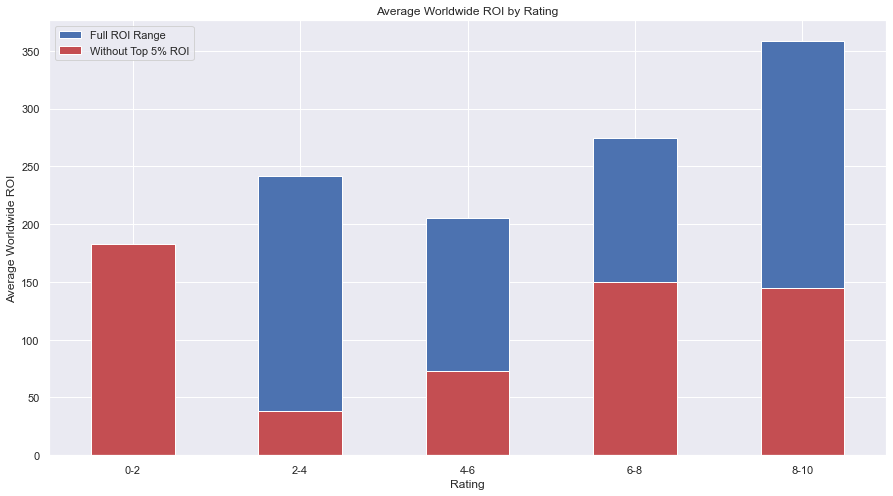

In [58]:
#Potentially play with style***

fig, ax = plt.subplots(figsize=(15,8))
g=rating_means_df.plot.bar(ax=ax, rot=0, x='rating_bins', y='worldwide_ROI', color='b')
g=rating_means_95th_df.plot.bar(ax=ax, rot=0, x='rating_bins', y='worldwide_ROI', color='r')
plt.legend(labels=['Full ROI Range', 'Without Top 5% ROI'])
g.set(title='Average Worldwide ROI by Rating', xlabel='Rating', ylabel='Average Worldwide ROI');

#### Runtime Analysis

In [89]:
#Aggregate DFs for runtime analysis
# runtime_means_df = br_inc_merged[br_inc_merged['worldwide_ROI']<2000].groupby('runtime_bins', as_index=False).mean()

runtime_means_df = br_inc_merged.groupby('runtime_bins', as_index=False).mean()
runtime_means_95th_df = br_inc_merged[ROI_95th_mask].groupby('runtime_bins', as_index=False).mean()

<ipython-input-89-8f5fc8f64ad3>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  runtime_means_95th_df = br_inc_merged[ROI_95th_mask].groupby('runtime_bins', as_index=False).mean()


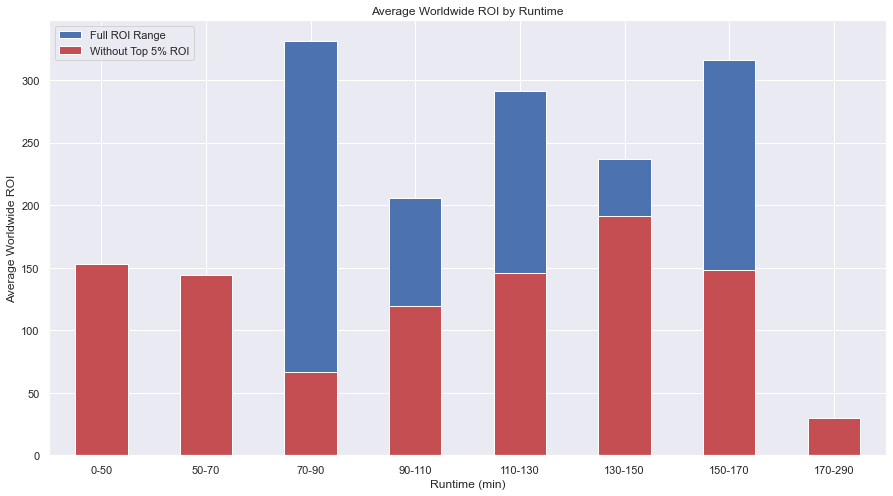

In [61]:
# fig, ax = plt.subplots(figsize=(15,8))
# # data_runtime_means = runtime_means_df.sort_values(by='', ascending=False);
# g = sns.barplot(data=runtime_means_df, x='runtime_bins', y='worldwide_ROI', ax=ax, color='b')
# g.set(title='Average Worldwide ROI by Runtime', xlabel='Runtime (min)', ylabel='Average Worldwide ROI');
# # g.set_xticks(range(0, 1500, 100));

fig, ax = plt.subplots(figsize=(15,8))
g=runtime_means_df.plot.bar(ax=ax, rot=0, x='runtime_bins', y='worldwide_ROI', color='b')
g=runtime_means_95th_df.plot.bar(ax=ax, rot=0, x='runtime_bins', y='worldwide_ROI', color='r')
plt.legend(labels=['Full ROI Range', 'Without Top 5% ROI'])
g.set(title='Average Worldwide ROI by Runtime', xlabel='Runtime (min)', ylabel='Average Worldwide ROI');

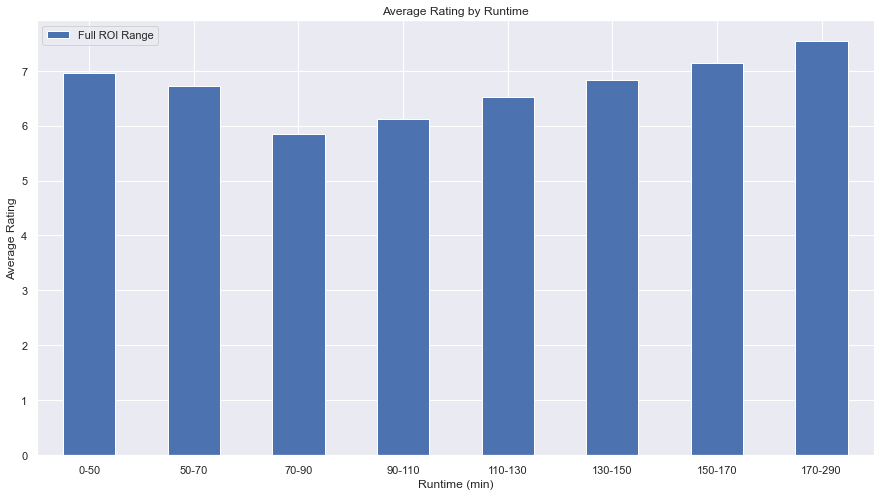

In [66]:
#POTENTIALLY REMOVE***

# fig, ax = plt.subplots(figsize=(15,8))
# # data_runtime_means = runtime_means_df.sort_values(by='', ascending=False);
# g = sns.barplot(data=runtime_means_df, x='runtime_bins', y='averagerating', ax=ax, color='b')
# g.set(title='Average Rating by Runtime', xlabel='Runtime (min)', ylabel='Average Rating');
# # g.set_xticks(range(0, 1500, 100));


fig, ax = plt.subplots(figsize=(15,8))
g=runtime_means_df.plot.bar(ax=ax, rot=0, x='runtime_bins', y='averagerating', color='b')
plt.legend(labels=['Full ROI Range', 'Without Top 5% ROI'])
g.set(title='Average Rating by Runtime', xlabel='Runtime (min)', ylabel='Average Rating');

#### Genre Analysis

In [75]:
genre_df_means = genre_df.groupby('genres', as_index=False).mean()

In [74]:
genre_df_means.head()

,genres,runtime_minutes,averagerating,production_budget,worldwide_gross,worldwide_income,worldwide_ROI
11,Horror,94.760684,5.351852,1.832485e+07,6.508887e+07,4.676402e+07,480.777767
13,Mystery,102.227273,6.025000,2.146802e+07,7.026393e+07,4.879591e+07,433.647596
16,Sport,109.459016,6.581967,2.420697e+07,7.903346e+07,5.482649e+07,355.135997
17,Thriller,102.116090,5.845214,2.747772e+07,8.196356e+07,5.448584e+07,340.423420
9,Fantasy,108.465116,6.008721,7.007436e+07,2.181551e+08,1.480807e+08,339.441263


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 11 to 5
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genres             18 non-null     object 
 1   runtime_minutes    18 non-null     float64
 2   averagerating      18 non-null     float64
 3   production_budget  18 non-null     float64
 4   worldwide_gross    18 non-null     float64
 5   worldwide_income   18 non-null     float64
 6   worldwide_ROI      18 non-null     float64
dtypes: float64(6), object(1)
memory usage: 1.1+ KB


DROP COUNTS LESS THAN 100

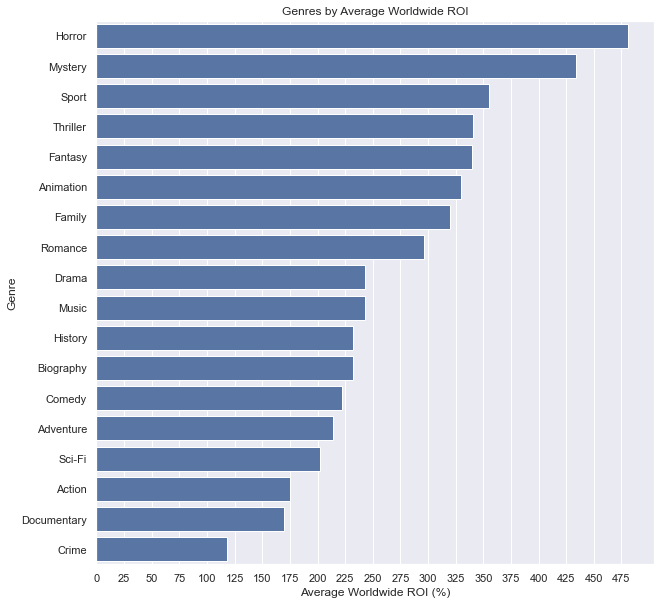

In [86]:
fig, ax = plt.subplots(figsize=(10,10))

data_mean_ROI = genre_df_means.sort_values(by='worldwide_ROI', ascending=False)

g1 = sns.barplot(data=data_mean_ROI, x='worldwide_ROI', y='genres', ax=ax, color='b')
g1.set(title='Genres by Average Worldwide ROI', xlabel='Average Worldwide ROI (%)', ylabel='Genre')
g1.set_xticks(range(0, 500, 25));

# fig, ax = plt.subplots(figsize=(10,10))
# genre_df_means.plot.barh(x='worldwide_ROI', y='genres', color='b')
# g.set(title='Genres by Average Worldwide ROI', xlabel='Average Worldwide ROI (%)', ylabel='Genre')
# g.set_xticks(range(0, 500, 25));


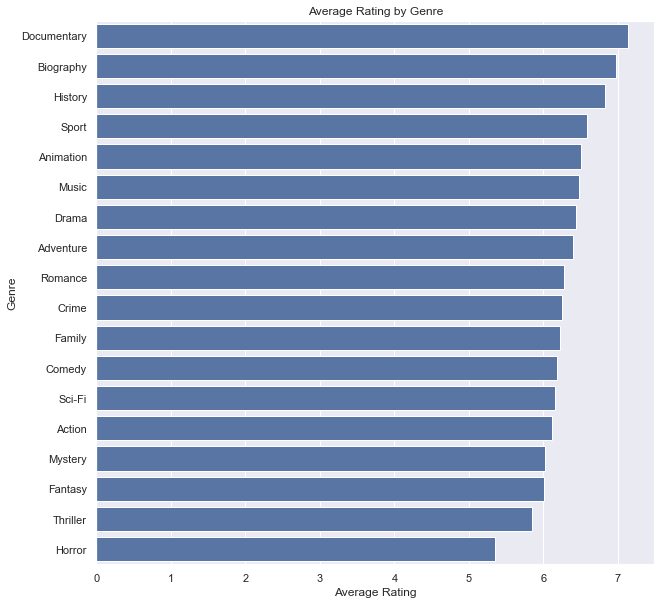

In [87]:
fig, ax = plt.subplots(figsize=(10,10))
data_mean_reviews = genre_df_means.sort_values(by='averagerating', ascending=False);
g = sns.barplot(data=data_mean_reviews, x='averagerating', y='genres', ax=ax, color='b')
g.set(title='Average Rating by Genre', xlabel='Average Rating', ylabel='Genre');
# g.set_xticks(range(0, 1500, 100));

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***